# Coursework1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs. 

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook and you can ignore the **tests** folder

#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the ```/content/``` directory (this is the default working directory - you can also change directories with ```%cd```)

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [27]:
!pip3 install -q otter-grader pandoc torch torchvision sklearn seaborn

In [28]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic pytorch operations to define the 2D convolution, 2D max pooling, linear layer as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not what to see any _for loops_!

**Your Task**
- implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        # ...
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = torch.ones((out_channels, in_channels, kernel_size, kernel_size)) # For testing
        # self.w = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))

        # Bias should have shape [out_channels] 
        if bias:
            self.b = torch.arange(out_channels)  # For testing
            # self.b = torch.zeros(out_channels)

        self.F = out_channels
        self.C = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.is_bias = bias
        ...
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass 

        # Store size of input
        (N, C, W_in, H_in) = x.size()
        
        # Calculate output width W'
        W_out = int((W_in - self.kernel_size + 2*self.padding) / self.stride + 1)
        # Calculate output height H'
        H_out = int((H_in - self.kernel_size + 2*self.padding) / self.stride + 1)

        w = self.w
        x_unf = F.unfold(x, (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        out_unf = x_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2) # https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
        out = out_unf.view(N, self.F, H_out, W_out)

        # Or equivalently: torch.nn.functional.conv2d(x, w)

        # Add bias
        if self.is_bias:
            b = self.b
            b = b.view(1, self.F, 1, 1)
             
            # Add appropriate bias to each output channel
            # Take advantage of broadcasting
            out += b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [30]:
grader.check("Convolution Layer")

# # Test
# myConvLayer = Conv2d(3, 3, 2, bias = True, stride=2 ,padding=2)

# # Create input of size 1 x 3 x 3 x 3 (B, C, H, W)
# input  = torch.arange(1, 1*3*3*3 + 1, dtype=torch.float32)
# input = input.view(1,3,3,3)

# out = myConvLayer.forward(input)

# # Compare to pytorch implementation
# m = nn.Conv2d(3, 3, 2, stride=2 ,padding=2)
# m.weight = torch.nn.Parameter(torch.ones((3, 3, 2, 2)))
# m.bias = torch.nn.Parameter(torch.arange(3, dtype=torch.float32))

# out_actual = m.forward(input)

# print(out_actual == out)

Convolution Layer results: All test cases passed!

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Convert kernel_size to a tuple if it is specified as a single number
        if type(kernel_size) != tuple:
            self.kernel_size = (kernel_size, kernel_size)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Extract all windows of size kernel_size x kernel_size
        x_windows = x.unfold(2, self.kernel_size[0], self.kernel_size[1]).unfold(3, self.kernel_size[0], self.kernel_size[1])

        # Flatten K x K windows into K*K vectors
        desired_size = *x_windows.size()[:-2], -1

        x_windows = x_windows.contiguous().view(desired_size) # https://github.com/pytorch/pytorch/pull/1523#issue-119774673

        # Replace the last dimension with the max value in that dimension
        out, _ = torch.max(x_windows, 4)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [32]:
grader.check("MaxPool Layer")

# print(input)

# # Create input of size 1 x 3 x 4 x 4 (B, C, H, W)
# input2  = torch.arange(1, 1*3*4*4 + 1, dtype=torch.float32)
# input2 = input2.view(1,3,4,4)

# print(input2)

# myMax2DLayer = MaxPool2d((2, 1))
# out = myMax2DLayer.forward(input2)

# print(out)
# # Compare to pytorch implementation

# m = nn.MaxPool2d((2, 1))

# out_actual = m.forward(input2)
# print(out_actual)

# out == out_actual

MaxPool Layer results: All test cases passed!

In [33]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = torch.ones(in_channels, out_channels)
        self.b = torch.arange(out_channels)
        ...
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = x @ self.w + self.b
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [34]:
grader.check("Linear Layer")

# # Create input of size 1 x 3 x 4 (B, C, H)
# input2  = torch.arange(1, 1*3*4 + 1, dtype=torch.float32)
# input2 = input2.view(1,3,4)

# print(input2.shape)
# print(input2)

# myLinearLayer = Linear(4, 5)
# out = myLinearLayer.forward(input2)

# print(out)
# # Compare to pytorch implementation

# m = nn.Linear(4, 5)

# m.weight = torch.nn.Parameter(torch.ones(5, 4))
# m.bias = torch.nn.Parameter(torch.arange(5, dtype=torch.float32))

# out_actual = m.forward(input2)

# # Check that all outputs are the same
# torch.all(out == out_actual)


Linear Layer results: All test cases passed!

In [35]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        
        #Initialize running mean and var
        self.running_mean = torch.zeros(1, num_features, 1, 1)
        self.running_var = torch.ones(1, num_features, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

     
        # Normalize by batch statistics if it is training time
        if self.training:
            # Find the expectation and variance calculated on N, H, W slices
            exp_x = torch.mean(x, [0, 2, 3], keepdim = True)
            var_x = torch.var(x, [0, 2, 3], keepdim = True, unbiased=False)
            unbiased_var_x = torch.var(x, [0, 2, 3], keepdim = True, unbiased=True)

            # Update the running mean and variance
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * exp_x
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbiased_var_x

            # Normalize the input to obtain the output
            out = (x - exp_x) / torch.sqrt(var_x + self.eps) * self.gamma.view(1, -1, 1, 1) + self.beta.view(1, -1, 1, 1)
        
        # Normalize by running statistics if it is inference time
        else:
            # Normalize the input to obtain the output
            out = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps) * self.gamma.view(1, -1, 1, 1) + self.beta.view(1, -1, 1, 1)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [36]:
grader.check("BatchNorm Layer")

# # Create input of size 1 x 3 x 4 (B, C, H, W)
# input2  = (torch.arange(1, 1*3*2*2 + 1, dtype=torch.float32))**2
# input2 = input2.view(1, 3, 2 , 2)

# print(input2)

# # Instantiate custom layer
# myBatchLayer = BatchNorm2d(3)

# out = myBatchLayer.forward(input2) 

# myBatchLayer.training = False
# out = myBatchLayer.forward(input2) 

# print(out)

# # Compare to pytorch module
# m = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1)
# out_actual = m.forward(input2)

# m.training = False
# out_actual = m.forward(input2) 

# print(out_actual)

# # Check that all outputs are the same
# precision = 1e-05
# print(torch.all((out - out_actual) < precision))

# # Compare running means
# # print(myBatchLayer.running_mean)
# # print(m.running_mean)
# print((myBatchLayer.running_var.view(-1) - m.running_var) < precision)

# # print(m.running_var)
# # print(myBatchLayer.running_var)


BatchNorm Layer results: All test cases passed!

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [37]:
ON_COLAB = False

# !wget "https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1"
# !wget "https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1"
# if ON_COLAB:
#     !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
#     !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
# else: 
#     !unzip NaturalImageNetTest.zip?download=1 > /dev/null
#     !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2022-02-03 15:50:06--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1’

NaturalImageNetTest 100%[===================>] 132.09M  4.98MB/s    in 51s     

2022-02-03 15:50:58 (2.61 MB/s) - ‘NaturalImageNetTest.zip?download=1’ saved [138507970/138507970]

--2022-02-03 15:50:59--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383630100 (1.3G) [application/octet-stream]
Saving to: ‘NaturalImageNetTrain.zip?download=1’

NaturalImageNetTrai 100%[===================>]   1.29G  2.57MB/s    in 6m 0s

In [38]:
#torch
import torch
# from torch.nn import Conv2d, MaxPool2d # will use them as nn.Conv2d not to confuse with custom implementation
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [39]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform_train = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            # transforms.RandomRotation(degrees = 30),
            # transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

transform_test = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_path, transform=transform_test)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)


train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [40]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))


**Visualising some example images** 

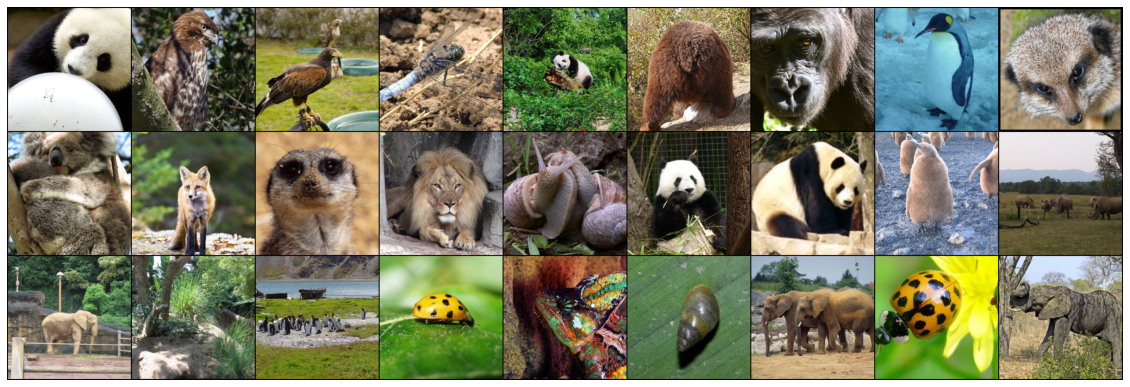

In [41]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [42]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 16
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(16), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        # self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        # self.layer7 = self.make_layer(ResidualBlock, 1024, 2, stride = 2)


        # self.maxpool = nn.MaxPool2d(2)
        # self.maxpool = nn.MaxPool2d(4)
        self.maxpool = nn.MaxPool2d(8)
        # self.maxpool = nn.MaxPool2d(16)

        # self.fc = nn.Linear(128, num_classes)
        # self.fc = nn.Linear(512, num_classes)
        # self.fc = nn.Linear(1024, num_classes)
        self.fc = nn.Linear(256, num_classes)

        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        # x = self.layer6(x)
        # x = self.layer7(x)      
        
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [44]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    # Define the learning rate drop scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=10**-0.5)
    
    for e in range(epochs):
        # Print lr
        print(f"Learning rate is {scheduler.get_last_lr()}")

        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

        # Decrease learning rate by sqrt(10) every 4 epochs
        scheduler.step()

        check_accuracy(loader_val, model)
                

cuda:0


In [50]:
# define and train the network
model = MyResNet()

# lr_list = [0.00001, 0.0001, 0.001] 28% 35% 55.76%
# lr_list = [0.0003, 0.003, 0.01] #45.85% 63.21% 64%
# lr_list = [0.01, 0.03, 0.1] # 60.86% #53.9% 46.80%

lr_list = [0.003]
num_epochs = 12

for lr in lr_list:
    optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=1e-3) #weight_decay=1e-7 original

    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total number of parameters is: {}".format(params))

    train_part(model, optimizer, epochs = num_epochs)


    # report test set accuracy
    check_accuracy(loader_val, model, analysis=True)


    # save the model
    filename = 'model_lr='+ str(lr) + "_ne=" + str(num_epochs) + '.pt'
    torch.save(model.state_dict(), filename)

Total number of parameters is: 2805316
Learning rate is [0.003]
Epoch: 0, Iteration 0, loss = 4.1823
Epoch: 0, Iteration 10, loss = 3.1995
Epoch: 0, Iteration 20, loss = 2.6565
Epoch: 0, Iteration 30, loss = 2.5371
Epoch: 0, Iteration 40, loss = 2.4264
Epoch: 0, Iteration 50, loss = 2.5895
Epoch: 0, Iteration 60, loss = 2.4662
Epoch: 0, Iteration 70, loss = 2.5831
Epoch: 0, Iteration 80, loss = 2.3832
Epoch: 0, Iteration 90, loss = 2.2168
Epoch: 0, Iteration 100, loss = 2.2564
Epoch: 0, Iteration 110, loss = 2.0450
Epoch: 0, Iteration 120, loss = 2.1263
Epoch: 0, Iteration 130, loss = 2.1844
Epoch: 0, Iteration 140, loss = 2.2067
Got 751 / 1998 correct of val set (37.59)
Learning rate is [0.003]
Epoch: 1, Iteration 0, loss = 1.8966
Epoch: 1, Iteration 10, loss = 1.7619
Epoch: 1, Iteration 20, loss = 2.0373
Epoch: 1, Iteration 30, loss = 1.9405
Epoch: 1, Iteration 40, loss = 1.7867


<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1455 / 2000 correct of val set (72.75)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


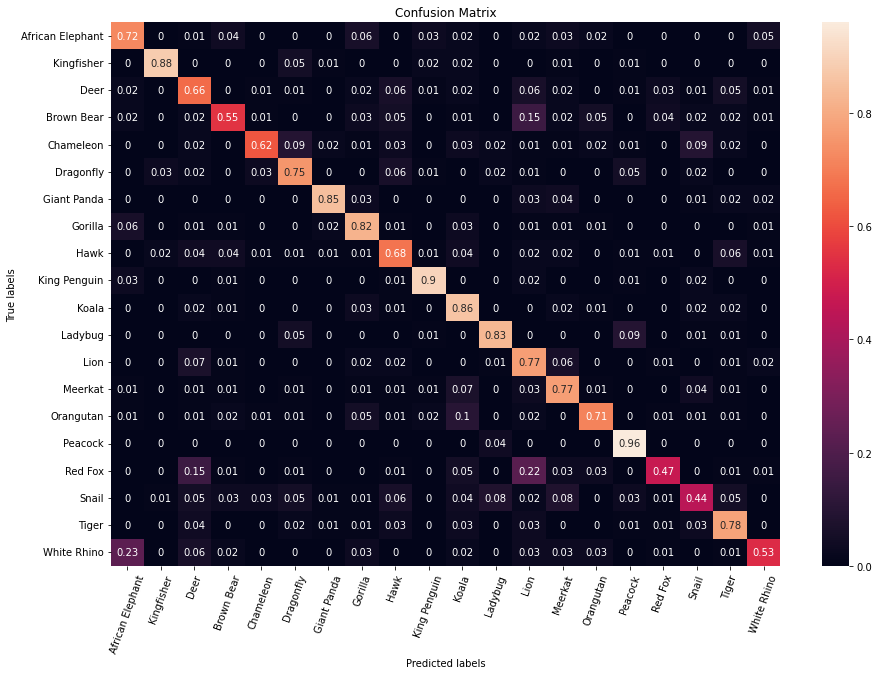

Predicted label ['African Elephant' 'Hawk' 'Snail' 'Ladybug' 'Tiger' 'Dragonfly' 'Lion'
 'Dragonfly' 'Chameleon']
True label ['Gorilla' 'Brown Bear' 'Chameleon' 'Snail' 'Chameleon' 'Hawk' 'Red Fox'
 'Tiger' 'Dragonfly']
Corresponding images are shown below
Got 16542 / 17986 correct of val set (91.97)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


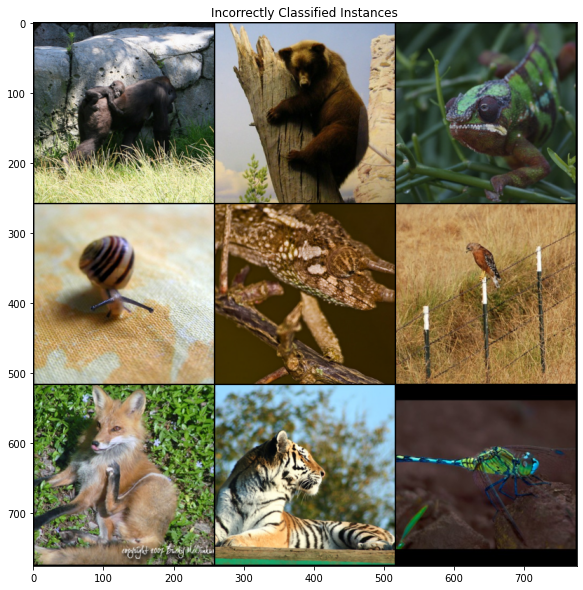

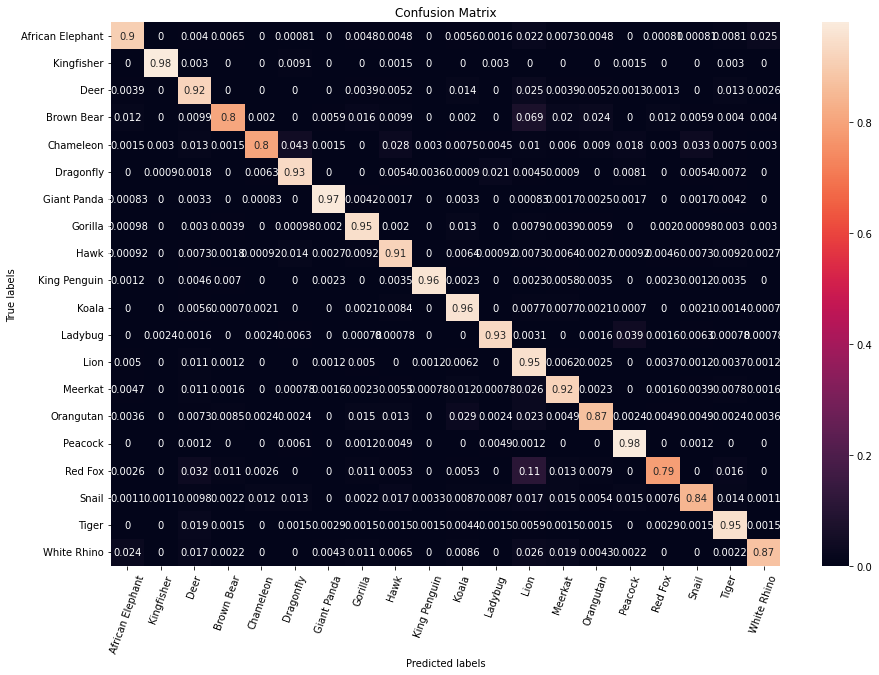

Predicted label ['Ladybug' 'King Penguin' 'Tiger' 'Snail' 'Peacock' 'Hawk']
True label ['Dragonfly' 'Dragonfly' 'Deer' 'Chameleon' 'Giant Panda' 'Tiger']
Corresponding images are shown below


0.9197153341487824

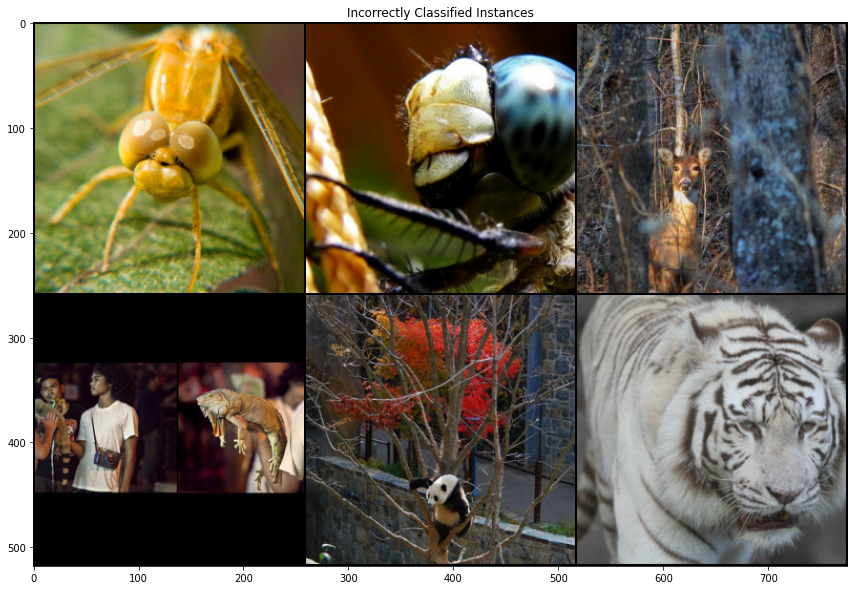

In [48]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

# # Compare to training loss for overfitting check
# check_accuracy(loader_train, model, analysis=True)

___

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

For hyperparameter search, I have studied the effect of the following parameters on the test accuracy:

1. Learning rate, learning rate drop factor and drop step
2. Number of epochs
3. Number of ResNet blocks in the network architecture 
4. Weight decay

Initially, I investigated the effect of changing the learning rate (keeping the other hyperparameters fixed). I explored the following values **lr_list = [0.00001, 0.0001, 0.001, 0.003, 0.01, 0.03, 0.1]**. The best test accuracy of **63%** was obtained with a learning rate of 0.003. I then moved on to explore the effect of the number of epochs. The validation accuracy kept improving until epoch 15 and then it started flattening at around **70%**. Since the training loss was still decreasing, this means that the network was starting to underfit. I choose the number of epoch to be 12 as a compromise between accuracy and training time and to avoid overfitting. Once identified the overfitting, I decided to experiment changing hyperparameters that could reduce overfitting. I have tried reducing the number of resnet modules from 6 to 5 and 4. Reducing the number of resnet modules to 4 decreased the number of learnable parameters from 44,779,076 to 703,044. This significantly reduced the training time but also led to model underfitting (**65%** accuracy). The best compromise was found with 5 resnet modules (2,805,316) hyperparameters, since this reduced the overfitting of the model and kept the training time manageable. To optimize the learning rate, I have also introduced a learining rate drop scheduler which showed the best results with a learn rate drop of sqrt(10) every 4 epochs. After this step, the test accuracy was **72%**. To reduce the overfitting further, I have experimented with the weight decay parameters of the Adam optimizer and found the optimal one to be **weight_decay=1e-3**. This lead to the final test accuracy of **75%**.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

In addition to the decisions described in Q2.1., I have also experimented with data augmentation by trying the following preprocessing transformations:
- Random rotation of up to 30 degrees
- Random vertical flippping with probability 0.5
- Random horizontal flipping with probability 0.5
- Color Jitter with brightness factor of 0.5 and hue factor of 0.3

Out of these transformations only the horizontal flipping had a positive effect on the accuracy. The other transformations probably made the training images too different from the test images. For example, the random rotation introduced a lot of black space in the boundaries and the color jitter made it harder to learn the color information of the animals. 
Out of the hyperparameters tuned, the learning rate had the highest effect since a high learning rate would escape the local minima and a small learing rate would make training too slow. The best startegy was to introduce a learning rate drop scheduler. This made learning faster in the beginning and more accurate towards the end.
Tuning the model complexity also had an important effect since reducing it decreased the overfitting and sped up the training, allowing to get to a higher accuracy with a relatively small number of epochs.
Another decision was early stopping for training since training for a very large number of epochs led to overfitting to the training set.

---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

The network start by gradually reducing the dimensionality of the image by sequentially extracting features from the previous layer and reducing the dimensionality of the input images. This allows to have a fully connected layer at the end (with a manageable number of parameters) that can classify based on the most abstract features extracted by the last layer. In summary:

- The first convolutional layers learn simple features such as edges.
- Later convolutional layers learn more complex features such as the textures of the fur of the animals.
- The last convolutional layers learn features such as ears, eyes and paws.
- The last fully connected layer learns to map the activations from the most abstract features to the specific class.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

The test accuracy of the network improved on the baseline of 50% and reached an accuracy of 75%. To see this in perspective, we can imagine that a network that guesses a class at random, would classify one out of 20 images correctly on average, which is an accuracy of 5%. This means that our network has learned to extract meaningful features to differentiate between the animals. We could also compare it to CoAtNet (https://paperswithcode.com/paper/coatnet-marrying-convolution-and-attention) which reached the best top-1 accuracy (90.88%) on the ImageNet dataset. This comparison does not take into account that training on the full ImageNet allows the network to learn better and more various features. Also, the CoAtNet has a more elaborate architecture than our resnet. 
Moreover, if we look at the set of miscalssified images, it is understandable why they were classified in correctly. In fact, these images included animals of the same colour of the environment (hard to distinguish) and close up photographies (like just a part of the face of the animal) that would be hard to distinguish even for humans.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

Other metrics such as precision, recall and f measure could be used to better describe the performance of the network. It would also be interesting to check what features the network would extract for pictures of things other than animals, to check if it learned features that are generic. We could also vary the percentage spilt between the test and training images. Incresing the test fraction would allow the network to learn more features but would also increase the error on the accuracy estimation since the test set would be smaller.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [ ]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    # vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



In [ ]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)